In [ ]:
!pip install scikit-learn==1.6.1 xgboost==2.1.4
# had to use specific versions because of compatability issues

In [ ]:
# data loading and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('/content/drive/MyDrive/loan predictor/train.csv')

train_df.info()

train_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:

print(train_df.describe())

print(train_df.isna().sum())


       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000         600.00000   
mean       5403.459283        1621.245798  146.412162         342.00000   
std        6109.041673        2926.248369   85.587325          65.12041   
min         150.000000           0.000000    9.000000          12.00000   
25%        2877.500000           0.000000  100.000000         360.00000   
50%        3812.500000        1188.500000  128.000000         360.00000   
75%        5795.000000        2297.250000  168.000000         360.00000   
max       81000.000000       41667.000000  700.000000         480.00000   

       Credit_History  
count      564.000000  
mean         0.842199  
std          0.364878  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education   

In [ ]:
# handling missing values
train_df['Gender'].fillna(train_df['Gender'].mode()[0], inplace=True)
train_df['Married'].fillna(train_df['Married'].mode()[0], inplace=True)
train_df['Dependents'].fillna(train_df['Dependents'].mode()[0], inplace=True)
train_df['Self_Employed'].fillna(train_df['Self_Employed'].mode()[0], inplace=True)
train_df['LoanAmount'].fillna(train_df['LoanAmount'].median(), inplace=True)
train_df['Loan_Amount_Term'].fillna(train_df['Loan_Amount_Term'].median(), inplace=True)
train_df['Credit_History'].fillna(train_df['Credit_History'].mode()[0], inplace=True)

/tmp/ipython-input-2073610878.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Gender'].fillna(train_df['Gender'].mode()[0], inplace=True)
/tmp/ipython-input-2073610878.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

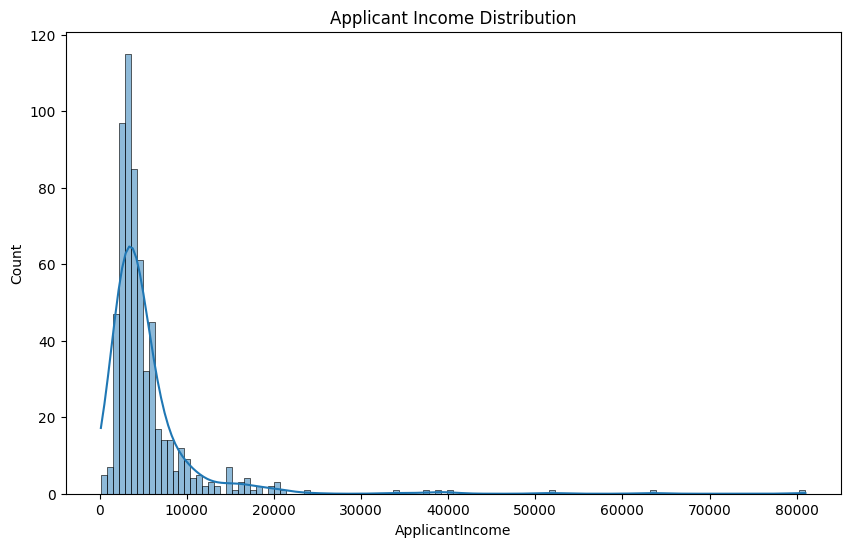

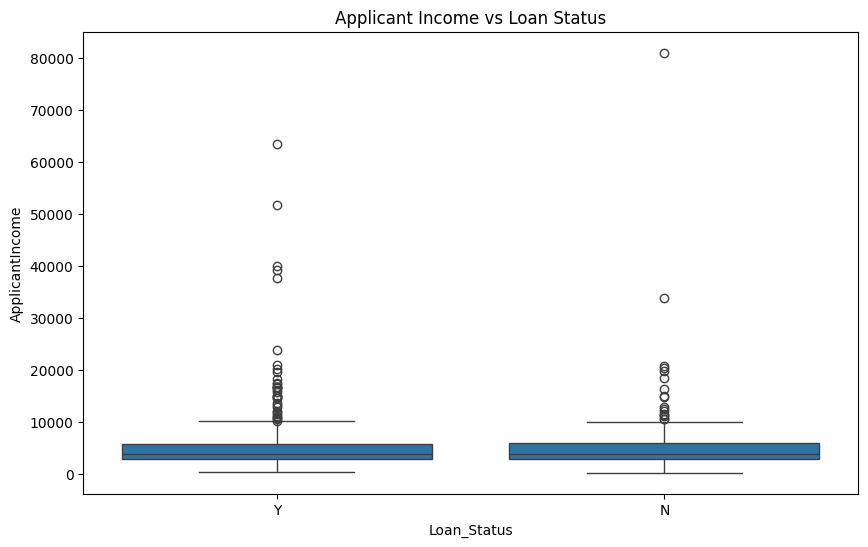

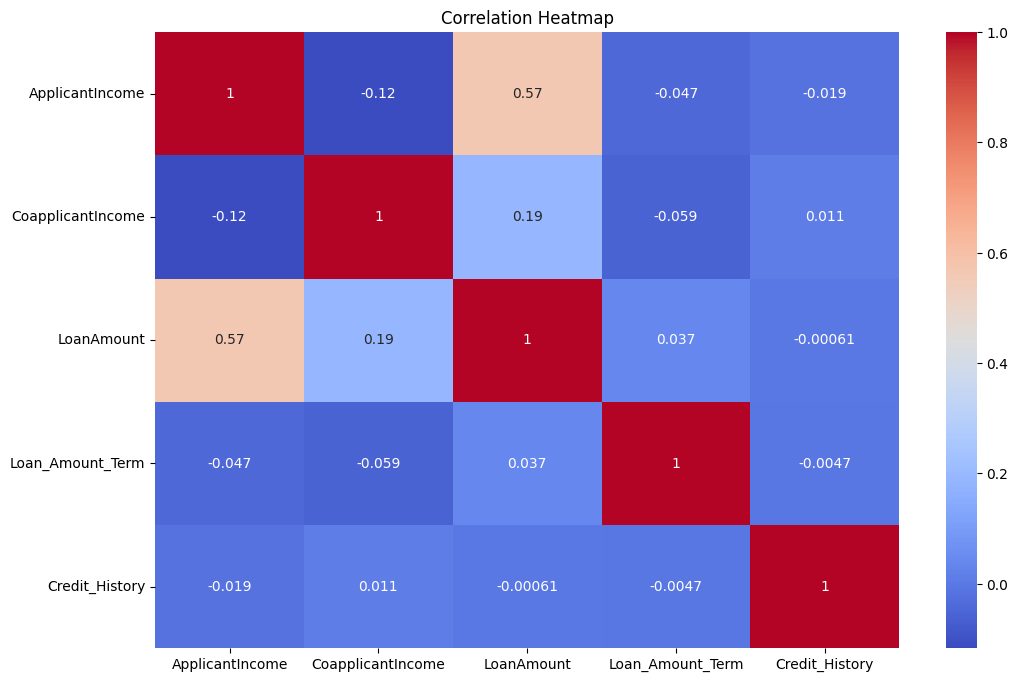

In [ ]:
# visualizations
plt.figure(figsize=(10,6))
sns.histplot(train_df['ApplicantIncome'], kde=True)
plt.title('Applicant Income Distribution')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='Loan_Status', y='ApplicantIncome', data=train_df)
plt.title('Applicant Income vs Loan Status')
plt.show()

plt.figure(figsize=(12,8))
sns.heatmap(train_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# data preprocessing and feature engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# defining features and target
X = train_df.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = train_df['Loan_Status'].map({'Y': 1, 'N': 0})  # Convert to binary

# spliting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# listing categorical and numerical columns
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# preprocessing transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [ ]:
# model training
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7560975609756098
              precision    recall  f1-score   support

           0       0.74      0.47      0.57        43
           1       0.76      0.91      0.83        80

    accuracy                           0.76       123
   macro avg       0.75      0.69      0.70       123
weighted avg       0.75      0.76      0.74       123



/usr/local/lib/python3.12/dist-packages/xgboost/core.py:158: UserWarning: [10:54:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


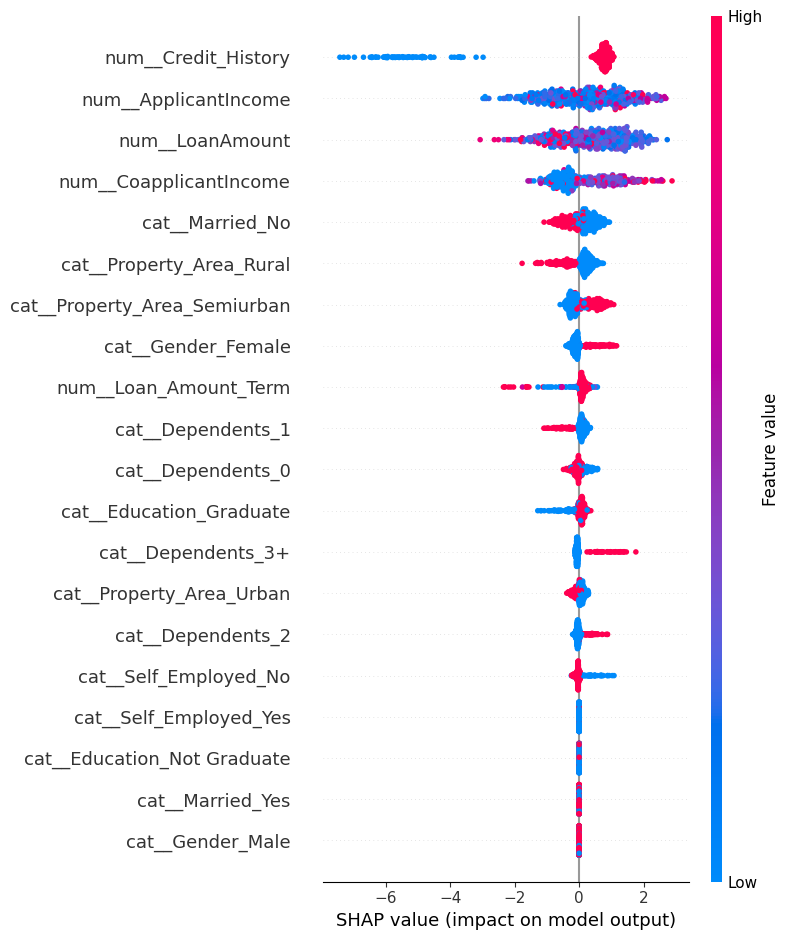

In [ ]:
# model explainability-SHAP
import shap

explainer = shap.TreeExplainer(model.named_steps['classifier'])
X_train_transformed = model.named_steps['preprocessor'].transform(X_train)
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=model.named_steps['preprocessor'].get_feature_names_out())

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_transformed[0,:], feature_names=model.named_steps['preprocessor'].get_feature_names_out())

In [ ]:
# model saving
import joblib

model_path = '/content/drive/MyDrive/loan predictor/loan_model.joblib'
joblib.dump(model, model_path)

['/content/drive/MyDrive/loan predictor/loan_model.joblib']

In [ ]:
from huggingface_hub import HfApi, login

HF_TOKEN = " HF TOKEN"
login(HF_TOKEN)

repo_name = "Ravichandrachilde/loan-prediction-XGB"

api = HfApi()
api.upload_file(
    path_or_fileobj="/content/drive/MyDrive/loan predictor/loan_model.joblib",
    path_in_repo="loan_model.joblib",
    repo_id=repo_name,
    token=HF_TOKEN,
    repo_type="model"
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...edictor/loan_model.joblib: 100%|##########|  173kB /  173kB            

CommitInfo(commit_url='https://huggingface.co/Ravichandrachilde/loan-prediction-XGB/commit/afb98f3f1e03d655816427995ae80fc69702cfa3', commit_message='Upload loan_model.joblib with huggingface_hub', commit_description='', oid='afb98f3f1e03d655816427995ae80fc69702cfa3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Ravichandrachilde/loan-prediction-XGB', endpoint='https://huggingface.co', repo_type='model', repo_id='Ravichandrachilde/loan-prediction-XGB'), pr_revision=None, pr_num=None)

In [ ]:
repo_name = "Ravichandrachilde/loan-prediction-dataset"

api = HfApi()
api.upload_file(
    path_or_fileobj="/content/drive/MyDrive/loan predictor/train.csv",
    path_in_repo="train.csv",
    repo_id=repo_name,
    token=HF_TOKEN,
    repo_type="dataset"
)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/Ravichandrachilde/loan-prediction-dataset/commit/1082d3f75dcb734363bed9a5f2a31e9756c98512', commit_message='Upload train.csv with huggingface_hub', commit_description='', oid='1082d3f75dcb734363bed9a5f2a31e9756c98512', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Ravichandrachilde/loan-prediction-dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Ravichandrachilde/loan-prediction-dataset'), pr_revision=None, pr_num=None)